In [1]:
# Benchmark Datasets
from benchmark import Benchmark

datasets = Benchmark.load_all_benchmark_datasets()

df = datasets["ecoli"]

In [2]:
# Standardize Dataset
from preprocessing import standardize

df = standardize(df)

In [3]:
# Set our RNG seed for reproducibility.
import numpy as np
from config import RANDOM_STATE_SEED
np.random.seed(RANDOM_STATE_SEED)

In [4]:
X_raw = df.loc[:, df.columns != 'target']#.to_numpy()
y_raw = df['target']#.to_numpy()

In [5]:
from config import WEIGHTED_TRAINING

# Samples weighting
from sklearn.utils.class_weight import compute_class_weight

def get_class_weight(y_train_init):
    if WEIGHTED_TRAINING:
        classes_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_init), y=y_train_init)
        CLASS_WEIGHT = {}
        for c, cw in list(zip(np.unique(y_train_init), classes_weights)):
            CLASS_WEIGHT[c] = cw
        print(CLASS_WEIGHT)
    else:
        CLASS_WEIGHT = None
    return CLASS_WEIGHT

# Hyperparameters tunning
from sklearn.base import ClassifierMixin
from sklearn.model_selection._search import  BaseSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, GridSearchCV, HalvingGridSearchCV
from sklearn.utils.class_weight import compute_sample_weight

def tune_classifiers_hyperparameters_cw(Clf: ClassifierMixin, X, y, params_grid, GridSearchMethod: BaseSearchCV,  scorer, class_weight=None, random_state=13, verbose=True) -> tuple:

    skf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
    # Any GridSearch assumes stratified folds if there is classifier
    if issubclass(GridSearchMethod, GridSearchCV):
        gs = GridSearchMethod(estimator=Clf(), param_grid=params_grid, scoring=scorer, refit=True, cv=skf)
    elif issubclass(GridSearchMethod, HalvingGridSearchCV):
        gs = GridSearchMethod(estimator=Clf(), param_grid=params_grid, scoring=scorer, refit=True, cv=skf, factor=2)
    else:
        raise ValueError("Unknown or unsupported BaseSearchCV") 

    if class_weight:
        sample_weight = compute_sample_weight(class_weight=class_weight, y=y)
    else:
        sample_weight = None
    gs.fit(X, y, sample_weight=sample_weight)

    if verbose:
        params_combinations = gs.cv_results_["params"]
        params_combinations_scores = gs.cv_results_["mean_test_score"]
        for i, params in enumerate(params_combinations):
            print(f"{params}\n{params_combinations_scores[i]}")

    return (gs.best_estimator_, gs.best_params_)

In [6]:
import warnings
from config import StoppingCriterion, BatchMode, AL_N_QUERIES, AL_QUERY_FIXED_BATCH_SIZE, AL_FRACTION_OF_TRAIN_QUERIES, AL_QUERY_FRACTION_OF_TRAIN_BATCH_SIZE
def perpare_queries_and_batch_size(stopping_criterion: StoppingCriterion, batch_mode: BatchMode, pool_size: int, init_train_size: int) -> tuple:
    match stopping_criterion.name:
        case "N_QUERIES":
            n_queries = AL_N_QUERIES
            match batch_mode.name:
                case 'FIXED_BATCH_SIZE':
                    batch_size = AL_QUERY_FIXED_BATCH_SIZE
                    if n_queries * batch_size > pool_size:
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
                        n_queries = int(n_queries/batch_size)
                case 'FRACTION_OF_N_QUERIES':
                    raise NotImplemented(f"{batch_mode.name} for {stopping_criterion.name} not implemented.") # TODO?
                case 'FRACTION_OF_TRAIN_SIZE':
                    raise NotImplemented(f"{batch_mode.name} for {stopping_criterion.name} not implemented.") # TODO?
        case "FRACTION_OF_TRAIN_QUERIES":
            n_queries = int((AL_FRACTION_OF_TRAIN_QUERIES * pool_size / 0.9) - init_train_size)
            match batch_mode.name:
                case 'FIXED_BATCH_SIZE':
                    batch_size = AL_QUERY_FIXED_BATCH_SIZE
                    if n_queries * batch_size > pool_size:
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
                        n_queries = int(n_queries/batch_size)
                case 'FRACTION_OF_N_QUERIES':
                    raise NotImplemented(f"{batch_mode.name} for {stopping_criterion.name} not implemented.")
                case 'FRACTION_OF_TRAIN_SIZE':
                    batch_size = int(AL_QUERY_FRACTION_OF_TRAIN_BATCH_SIZE * pool_size / 0.9)
                    if n_queries * batch_size > pool_size:
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
                        n_queries = int(n_queries/batch_size)
        # TODO: Add debuging of number of queries

        case "ENTROPY_CONFIDENCE":
            n_queries = pool_size
            batch_size = AL_QUERY_FIXED_BATCH_SIZE
            if n_queries * batch_size > pool_size:
                        n_queries = int(n_queries/batch_size)
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
            n_decline_rounds = 0

    return n_queries, batch_size

In [7]:
import warnings, copy, time
from collections import Counter

from config import TEST_SIZE, INITIAL_TRAIN_SIZE, WEIGHTED_TRAINING, VERBOSE, PARAMS_GRID
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB

from metrics import method_eval, f2_score

from modAL import ActiveLearner
from modAL.expected_error import expected_error_reduction
from modAL.uncertainty import classifier_entropy
from modAL.utils.data import data_vstack

results = {"folds": []}

# Stratified K-Folds cross-validator
skf = StratifiedKFold(n_splits=int(1/TEST_SIZE), random_state=RANDOM_STATE_SEED, shuffle=True) 
for k, (kf_train_indices, kf_test_indices) in enumerate(skf.split(X_raw, y_raw)):

    fold_results = {}

    if VERBOSE:
        print(50*'*')
        print(f"Fold no.{k+1}")
        print(50*'*')

    # K-Fold train and test
    X_train, X_test, y_train, y_test = X_raw.iloc[kf_train_indices], \
    X_raw.iloc[kf_test_indices], y_raw.iloc[kf_train_indices], y_raw.iloc[kf_test_indices]
    
    # K-Fold pool from train
    X_train_init, X_pool, y_train_init, y_pool = train_test_split(X_train, y_train, \
                                                    train_size=INITIAL_TRAIN_SIZE, stratify=y_train, random_state=RANDOM_STATE_SEED)
    

    class_weight = get_class_weight(y_train_init)
    
    Clf = GaussianNB # TODO: Refactor to map factory

    _, params = tune_classifiers_hyperparameters_cw(Clf, X_train_init, y_train_init, params_grid=PARAMS_GRID[Clf.__name__], GridSearchMethod=GridSearchCV, scorer=f2_score, class_weight=class_weight, random_state=RANDOM_STATE_SEED, verbose=VERBOSE)
    # params = {}
    sample_weight = compute_sample_weight(class_weight=class_weight, y=y_train_init) if WEIGHTED_TRAINING else None

    learner = ActiveLearner(estimator=Clf(**params), X_training=X_train_init, y_training=y_train_init, query_strategy=expected_error_reduction, sample_weight=sample_weight) # TODO: Refactor to map factory

    model = Clf(**params)

    sample_weight = compute_sample_weight(class_weight=class_weight, y=y_train) if WEIGHTED_TRAINING else None

    model.fit(X_train, y_train, sample_weight=sample_weight)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    print("Full dataset model")
    print(50*'-')
    full_model_score = method_eval(y_test=y_test, y_pred=y_pred, y_proba=y_proba, verbose=VERBOSE)
    print(50*'-')

    fold_results["full_model"] = full_model_score

    # Evaluate initial model
    y_pred = learner.predict(X_test)
    y_proba = learner.predict_proba(X_test)

    print("Initial model")
    print(50*'-')
    unqueried_score = method_eval(y_test=y_test, y_pred=y_pred, y_proba=y_proba, verbose=VERBOSE)
    print(50*'-')

    fold_results["initial_model"] = unqueried_score

    
    learner_al = copy.deepcopy(learner)
    X_pool_al, y_pool_al = copy.deepcopy(X_pool), copy.deepcopy(y_pool)

    warnings.simplefilter(action='ignore', category=FutureWarning)

    from config import StoppingCriterion, BatchMode, AL_N_DECLINE_ROUNDS
    stopping_criterion  = StoppingCriterion.FRACTION_OF_TRAIN_QUERIES
    batch_mode = BatchMode.FIXED_BATCH_SIZE
    n_queries, batch_size = perpare_queries_and_batch_size(stopping_criterion, batch_mode, len(y_pool_al), len(learner.y_training))

    # AL statistics
    queried_classes_counter = Counter()
    performance_history = [unqueried_score["metrics"]]
    iterations_time_history = []
    initial_confidence = np.mean(classifier_entropy(learner_al, X_test))
    entropy_confidence_history = [initial_confidence]

    if VERBOSE:
        print(50*'=')
        print(f"Active Learning")
        print(50*'=')

    # Allow our model to query unlabeled dataset for the most
    # informative points according to our query strategy (uncertainty sampling).
    for index in range(n_queries):
        start = time.perf_counter()
        query_index, query_instance = learner_al.query(X_pool_al.to_numpy(), n_instances=batch_size)

        # To track which samples are choosen. It is usefull, when comparing different algorithms.
        global_query_index = X_pool_al.iloc[query_index].index

        print(f"\n{index+1}. iteration: \nChosen sample was of an index: {global_query_index[-1]}\nChosen sample was of a class: {y_pool_al.iloc[query_index]}\n")
        queried_classes_counter.update(y_pool_al.iloc[query_index])

        # Teach our ActiveLearner model the record it has requested.
        X, y = X_pool_al.iloc[query_index], y_pool_al.iloc[query_index]
        if WEIGHTED_TRAINING:
            new_y = data_vstack((learner_al.y_training, y))
            sample_weight = compute_sample_weight(class_weight=class_weight, y=new_y)
        else:
            sample_weight = None
        learner_al.teach(X=X.to_numpy(), y=y.to_numpy(), sample_weight=sample_weight) # implicitly it gets fit_kwargs -> sample_weight
        # learner_al.teach(X=X, y=y, sample_weight=sample_weight, bootstrap=True, stratify=True) # for Query-By-Bagging


        # Remove the queried instance from the unlabeled pool.
        X_pool_al, y_pool_al = X_pool_al.drop(global_query_index), y_pool_al.drop(global_query_index)

        # Calculate and report our model's accuracy.
        y_pred = learner_al.predict(X_test)
        y_proba = learner_al.predict_proba(X_test)
        print(50*'-')
        model_evaluation = method_eval(y_test=y_test, y_pred=y_pred, y_proba=y_proba, verbose=VERBOSE)
        print(50*'-')

        # Save our model's performance for plotting.
        performance_history.append(model_evaluation["metrics"])

        # Entropy confidence
        entropy_confidence_history.append(np.mean(classifier_entropy(learner_al, X_test)))
        if stopping_criterion == "ENTROPY_CONFIDENCE":
            if entropy_confidence_history[-1] < entropy_confidence_history[-2]:
                n_decline_rounds += 1
            else:
                n_decline_rounds = 0
            if n_decline_rounds >= AL_N_DECLINE_ROUNDS:
                break
            if len(y_pool_al) < batch_size:
                break
        
        elapsed = time.perf_counter() - start
        iterations_time_history.append(elapsed)
    
    print(f"Queried samples:\n {queried_classes_counter}")
    n_queries = sum(queried_classes_counter.values())
    print(f"{len(y_train_init) + n_queries} out of {len(y_train)} samples seen.")
    print(f"Average iteration time was {np.mean(iterations_time_history):0.2f}s")

    fold_results["al_final_model"] = {"metrics": performance_history[-1]}
    fold_results["al_metrics"] = performance_history
    fold_results["al_confidence"] = entropy_confidence_history
    fold_results["al_queries"] = queried_classes_counter
    fold_results["avg_time_of_query"] = np.mean(iterations_time_history)
    results["folds"].append(fold_results)


**************************************************
Fold no.1
**************************************************
{'var_smoothing': 1}
0.5666666666666667
{'var_smoothing': 0.001}
0.2
{'var_smoothing': 1e-06}
0.2
{'var_smoothing': 1e-09}
0.2
Full dataset model
--------------------------------------------------
accuracy: 0.8823529411764706,
precision: 0.4444444444444444,
recall: 0.5714285714285714,
f2_score: 0.5405405405405406,
auc_pr_curve: 0.4960525148781807,
auc_roc_curve: 0.8220140515222482
--------------------------------------------------
Initial model
--------------------------------------------------
accuracy: 0.8970588235294118,
precision: 0.5,
recall: 0.42857142857142855,
f2_score: 0.44117647058823534,
auc_pr_curve: 0.612133048891809,
auc_roc_curve: 0.8594847775175645
--------------------------------------------------
Active Learning


/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



1. iteration: 
Chosen sample was of an index: 27
Chosen sample was of a class: 27   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8970588235294118,
precision: 0.5,
recall: 0.42857142857142855,
f2_score: 0.44117647058823534,
auc_pr_curve: 0.6186265553853155,
auc_roc_curve: 0.8618266978922717
--------------------------------------------------

2. iteration: 
Chosen sample was of an index: 134
Chosen sample was of a class: 134   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8970588235294118,
precision: 0.5,
recall: 0.42857142857142855,
f2_score: 0.44117647058823534,
auc_pr_curve: 0.6193261850194623,
auc_roc_curve: 0.8665105386416863
--------------------------------------------------

3. iteration: 
Chosen sample was of an index: 90
Chosen sample was of a class: 90   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8970588235294118,
precision: 0.5,
r

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



1. iteration: 
Chosen sample was of an index: 178
Chosen sample was of a class: 178   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9104477611940298,
precision: 0.5714285714285714,
recall: 0.5714285714285714,
f2_score: 0.5714285714285714,
auc_pr_curve: 0.5288810395953253,
auc_roc_curve: 0.9523809523809524
--------------------------------------------------

2. iteration: 
Chosen sample was of an index: 226
Chosen sample was of a class: 226    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.9104477611940298,
precision: 0.5714285714285714,
recall: 0.5714285714285714,
f2_score: 0.5714285714285714,
auc_pr_curve: 0.7041280148423006,
auc_roc_curve: 0.969047619047619
--------------------------------------------------

3. iteration: 
Chosen sample was of an index: 236
Chosen sample was of a class: 236    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.910447

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



1. iteration: 
Chosen sample was of an index: 163
Chosen sample was of a class: 163   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8805970149253731,
precision: 0.3333333333333333,
recall: 0.14285714285714285,
f2_score: 0.16129032258064516,
auc_pr_curve: 0.5176189774155275,
auc_roc_curve: 0.9142857142857144
--------------------------------------------------

2. iteration: 
Chosen sample was of an index: 157
Chosen sample was of a class: 157   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8805970149253731,
precision: 0.3333333333333333,
recall: 0.14285714285714285,
f2_score: 0.16129032258064516,
auc_pr_curve: 0.5176189774155276,
auc_roc_curve: 0.9142857142857144
--------------------------------------------------

3. iteration: 
Chosen sample was of an index: 203
Chosen sample was of a class: 203   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



1. iteration: 
Chosen sample was of an index: 227
Chosen sample was of a class: 227    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8507462686567164,
precision: 0.2857142857142857,
recall: 0.2857142857142857,
f2_score: 0.2857142857142857,
auc_pr_curve: 0.420151574538007,
auc_roc_curve: 0.8047619047619048
--------------------------------------------------

2. iteration: 
Chosen sample was of an index: 84
Chosen sample was of a class: 84   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8656716417910447,
precision: 0.3333333333333333,
recall: 0.2857142857142857,
f2_score: 0.2941176470588235,
auc_pr_curve: 0.420151574538007,
auc_roc_curve: 0.8047619047619048
--------------------------------------------------

3. iteration: 
Chosen sample was of an index: 309
Chosen sample was of a class: 309   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.850746268

/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



1. iteration: 
Chosen sample was of an index: 222
Chosen sample was of a class: 222   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8955223880597015,
precision: 0.0,
recall: 0.0,
f2_score: 0,
auc_pr_curve: 0.3994708722649899,
auc_roc_curve: 0.9190476190476191
--------------------------------------------------

2. iteration: 
Chosen sample was of an index: 20
Chosen sample was of a class: 20   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8955223880597015,
precision: 0.0,
recall: 0.0,
f2_score: 0,
auc_pr_curve: 0.40589222868634633,
auc_roc_curve: 0.9214285714285715
--------------------------------------------------

3. iteration: 
Chosen sample was of an index: 51
Chosen sample was of a class: 51   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.8955223880597015,
precision: 0.0,
recall: 0.0,
f2_score: 0,
auc_pr_curve: 0.40589222868634633,
auc_roc

In [8]:
original_string = """
accuracy: 0.8823529411764706,
precision: 0.4444444444444444,
recall: 0.5714285714285714,
f2_score: 0.5405405405405406,
auc_pr_curve: 0.4960525148781807,
auc_roc_curve: 0.8220140515222482
"""

# Extract numerical values using regular expressions
import re
values = re.findall(r'\d+\.\d+', original_string)

# Format the values as requested
formatted_string = ' & '.join(map(lambda x: f"{float(x):.4f}", values))

print(formatted_string)

0.8824 & 0.4444 & 0.5714 & 0.5405 & 0.4961 & 0.8220


In [9]:
# Metrics averaging
## Extracting information
cv_results = {}
for fold in results["folds"]:
    for k in fold.keys():
        if "model" in k:
            if k in cv_results:
                for m in cv_results[k].keys():
                    cv_results[k][m] += fold[k]["metrics"][m]
            else:
                cv_results[k] = fold[k]["metrics"]

folds_no = len(results["folds"])

if VERBOSE:
        print(50*'=')
        print(f"Averaged CV results")
        print(50*'=')

## Averaging
for model in cv_results.keys():
    if VERBOSE:
        print(50*'*')
        print(f"{model}")
        print(50*'*')
    for metric in cv_results[model]:
        cv_results[model][metric] /= folds_no
        if VERBOSE:
            print(f"'{metric}': ", cv_results[model][metric])

Averaged CV results
**************************************************
full_model
**************************************************
'accuracy':  0.8302019315188762
'precision':  0.38230463199772663
'recall':  0.8
'f2_score':  0.6352521639286346
'auc_pr_curve':  0.5423500856400314
'auc_roc_curve':  0.9024980483996877
**************************************************
initial_model
**************************************************
'accuracy':  0.8928446005267778
'precision':  0.3942857142857143
'recall':  0.3142857142857142
'f2_score':  0.32562706900942195
'auc_pr_curve':  0.5197634745172808
'auc_roc_curve':  0.891896955503513
**************************************************
al_final_model
**************************************************
'accuracy':  0.8719490781387181
'precision':  0.3246428571428571
'recall':  0.5142857142857142
'f2_score':  0.4440039440723435
'auc_pr_curve':  0.47593239194899734
'auc_roc_curve':  0.8989461358313818


In [10]:
for model in cv_results.keys():
    print(model)
    for x in cv_results[model].values():
        print(f"{x:.4f} & ", end="")
    print("\n")

full_model
0.8302 & 0.3823 & 0.8000 & 0.6353 & 0.5424 & 0.9025 & 

initial_model
0.8928 & 0.3943 & 0.3143 & 0.3256 & 0.5198 & 0.8919 & 

al_final_model
0.8719 & 0.3246 & 0.5143 & 0.4440 & 0.4759 & 0.8989 & 



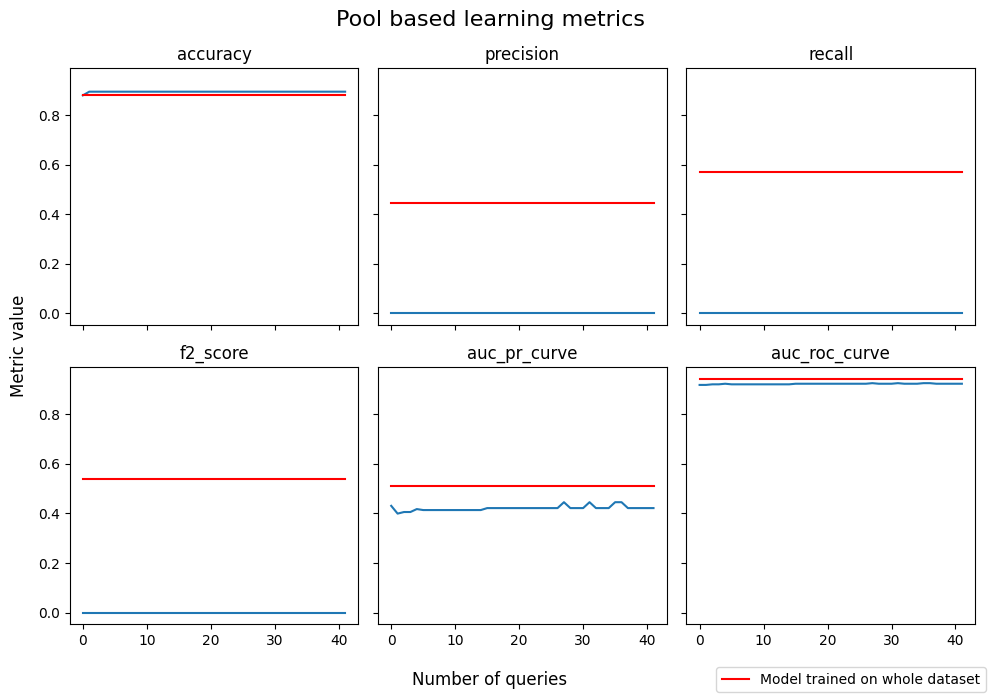

In [16]:
from matplotlib import pyplot as plt

# Fold
fold = 4 # 0-4

performance_history = results["folds"][fold]["al_metrics"]
full_model_score = results["folds"][fold]["full_model"]

# Plotting metrics
fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

if len(full_model_score) == 2:
    full_model_score = list(full_model_score["metrics"].values())
metrics = list(zip(*[x.values() for x in performance_history]))

for i, metric_name in enumerate(performance_history[0].keys()):
    axs[int(i/3), int(i%3)].plot(range(len(metrics[i])), metrics[i])
    handle = axs[int(i/3), int(i%3)].plot(range(len(metrics[i])), np.ones(len(metrics[i]))*full_model_score[i], "r")
    axs[int(i/3), int(i%3)].set_title(metric_name)

fig.suptitle("Pool based learning metrics", fontsize=16)
fig.supxlabel("Number of queries")
fig.supylabel("Metric value")
fig.legend(handle, ["Model trained on whole dataset"], loc='lower right')
fig.tight_layout()